In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 

## Homework 3: Polynomial and LASSO Regression

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
from collections import Counter
import math
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data visualization [4 pts]**](#part1)

- [**Your Homework 3 roadmap**](#roadmap)


- [**Question 2: Guesstimate the polynomial relationship [22 pts]**](#part2)

- [**Question 3: Use a validation set to find the most promising polynomial relationship [12 pts]**](#part3)

- [**Question 4: Finding the best model by k-fold cross validation [14 pts]**](#part4)

- [**Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]**](#part5)

- [**Question 6: Improving model consistency with LASSO regularization [26 pts]**](#part6)

- [**Question 7: Analyze your best test MSEs for each section of the homework [6 pts]**](#part7)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting percentage change in bacteria populations given their spreading factor

In this homework, we will explore polynomial regression for modeling a quantitative variable. Specifically, we will model the percent change in a bacteria population after 4 hours as a function of the bacteria's "spreading factor".

**The data set for this problem has already been split for you.** You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively.

### Problem Description

We will predict the percentage change in population, given the spreading factor. Thus, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. Using mean squared error ($MSE$) as an evaluative criteria, we will explore several different approaches for finding the best fit and most robust polynomial regression for modeling this relationship.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data visualization [4 pts]</div> 
    
[Return to contents](#contents)
    

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1</b></div>

Generate a *well-labeled* scatter plot of the data points in the `bacteria_train.csv` file with the spreading factor on the $x$-axis and the percentage change on the $y$-axis.

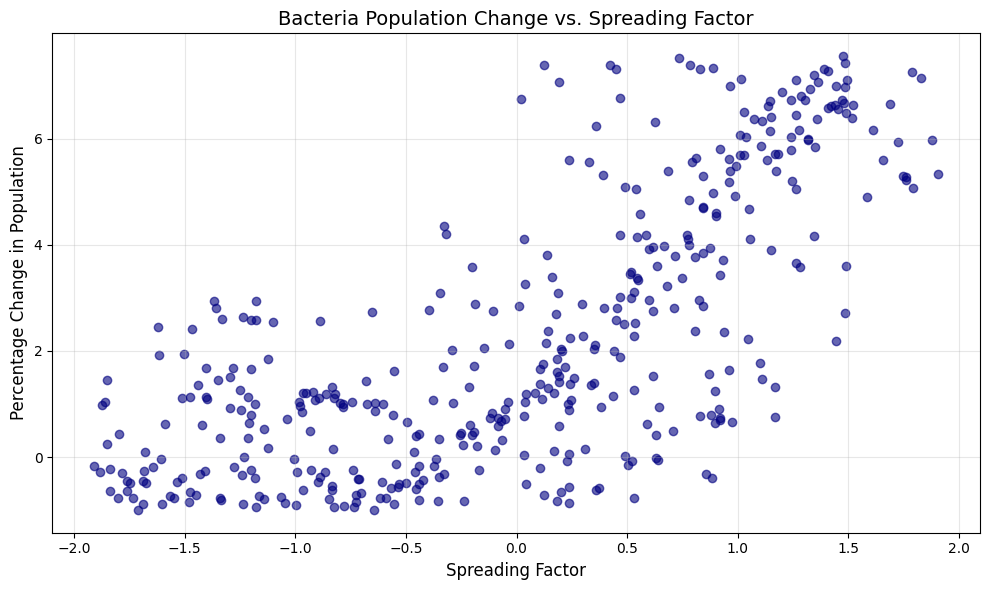

In [5]:
# your code here
train_data = pd.read_csv('data/bacteria_train.csv')


plt.figure(figsize=(10, 6))  

# Create scatter plot
plt.scatter(train_data['Spreading_factor'], 
           train_data['Perc_population'], 
           alpha=0.6,  
           color='navy')  

# labels
plt.xlabel('Spreading Factor', fontsize=12)
plt.ylabel('Percentage Change in Population', fontsize=12)
plt.title('Bacteria Population Change vs. Spreading Factor', fontsize=14)

# grid
plt.grid(True, alpha=0.3)


plt.tight_layout()


plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2</b></div>

Based on the graph above, is there any discernable relationship between the spreading factor and percentage change in population? If so, how would you describe this relationship?

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

There is a clear positive nonlinear relationship between the spreading factor and percentage change in population. As the spreading factor increases, the percentage change in population tends to increase as well.  The relationship appears to be nonlinear, with what looks like an S-shaped. There's a lot of variability in the percentage change at any given spreading factor, suggesting that while there's a clear relationship, other factors may also influence the population change. THis would be well fit for a polynomial regression. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="roadmap"></a>

<hr style='height:2px'> 

## Your Homework 3 roadmap

[Return to contents](#contents)

**We will be following this roadmap throught the notebook**

![](./data/roadmap.png)


<a id="part2"></a>

## <div class='exercise'>Question 2: Guesstimate the polynomial relationship [22 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1</b></div>

Based on your inspection in question 1, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. 

**Notes:**
- **You don't need to scale your data in this assignment** (you can inspect the data to see why this might not be necessary)
- **You should *not* include a bias in the design matrix you intend to pass to the linear regression's `fit` method.**

In [6]:
# your code here
guessed_deg = 3 # this is because it is S shaped which is the shape of odd degrees. low still to avoid overfitting.

poly = PolynomialFeatures(degree=guessed_deg, include_bias=False)
x_poly_train = poly.fit_transform(train_data[['Spreading_factor']])

test_data = pd.read_csv('data/bacteria_test.csv')
x_poly_test = poly.transform(test_data[['Spreading_factor']])


In [7]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2</b></div>

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '2.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

**Hint:** Because you will be calculating MSEs for models through this notebook, you may want to abstract this process into a function for re-use.

In [8]:
# Fit a linear regression model
# your code here
from sklearn.metrics import mean_squared_error 

results = []


poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, train_data['Perc_population'])

train_pred = poly_reg.predict(x_poly_train)
test_pred = poly_reg.predict(x_poly_test)

train_mse = mean_squared_error(train_data['Perc_population'], train_pred)
test_mse = mean_squared_error(test_data['Perc_population'], test_pred)

results.append({
    'model': '2.2',
    'train_mse': train_mse,
    'test_mse': test_mse
})

print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")



Training MSE: 2.6534
Test MSE: 2.6519


In [9]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.653407,2.651906


In [10]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3</b></div>

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.
  

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

A polynomail regression of degree 3 is the smallest degree that can capture the S shape of the data. Higher degrees might overfit to noise in the data. Lower degrees (1 or 2) wouldn't capture the inflection points in the relationship. The model captures the overall nonlinear trend in the data and The S-shaped pattern is well represented. 


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


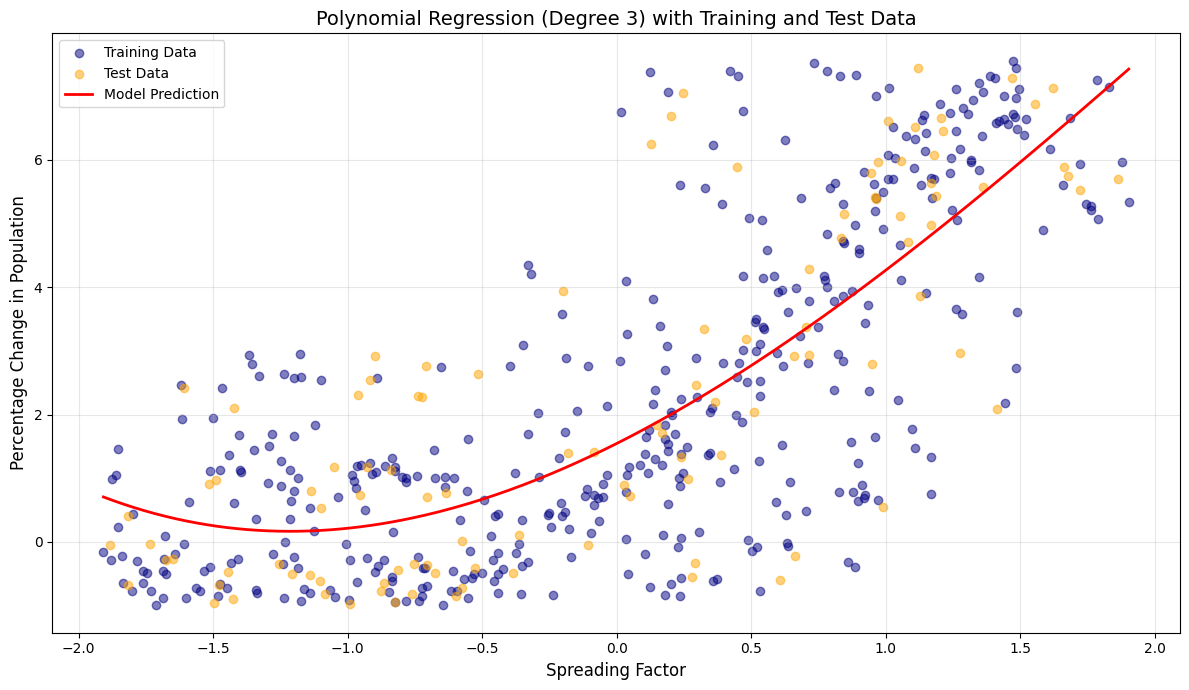


Model Performance:
  model  train_mse  test_mse
0   2.2   2.653407  2.651906


In [11]:
# your code here


x_range = np.linspace(train_data['Spreading_factor'].min(), 
                      train_data['Spreading_factor'].max(), 
                      300).reshape(-1, 1)

x_range_poly = poly.transform(x_range)
y_pred_smooth = poly_reg.predict(x_range_poly)

# plot specifications
plt.figure(figsize=(12, 7))
plt.scatter(train_data['Spreading_factor'], train_data['Perc_population'], 
           alpha=0.5, label='Training Data', color='navy')
plt.scatter(test_data['Spreading_factor'], test_data['Perc_population'], 
           alpha=0.5, label='Test Data', color='orange')


plt.plot(x_range, y_pred_smooth, 'r-', label='Model Prediction', linewidth=2)
plt.xlabel('Spreading Factor', fontsize=12)
plt.ylabel('Percentage Change in Population', fontsize=12)
plt.title('Polynomial Regression (Degree 3) with Training and Test Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# df representation of results
results_df = pd.DataFrame(results)
print("\nModel Performance:")
print(results_df)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4</b></div>

Now we will compute confidence intervals for the coefficients generated by our model specification. For the same degree polynomial regression fit above in 2.2, compute and plot the 95% confidence interval of the beta (i.e. $\beta$) values obtained in that regression model. Be certain to meet these primary requirements:
- Report the coefficient values of the model fit above in 2.2.
- Use bootstrapping to generate your 95% confidence intervals by refitting your model to each bootstrapped sample of your training data. You should use **100 bootstrapped samples**.
- For each bootstrap, store the coefficients of the model, and use those stored coefficients to compute the $2.5$ and $97.5$ confidence bounds.
- Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$, illustrating the distribution of bootstrapped coefficients for each $\beta_i$. Each distribution should indicate the regions of 95% confidence. Use `plt.subplots(...)` to arrange your histograms as a grid of plots.
- Comment on your findings.

**Note:** Our use of the term "coefficients" includes the intercept. So the intercept should also get a confidence interval plot.

**Hints:** Wrapping your plotting code in a function may make the solution to the next question more concise.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

This indicates that beta 0 throught beta 2 inclusibe are statistically significant based on the CIs. this is an important finding because it helps us identify whether we needed to have such high degree (3). it appears that this additional term was unnecessary. we only needed to include up to degreee 2 based on the bootstrapping. we know this becuase none of the betas CI contain 0 except beta 3 -- indicating that we have not observed it to be signficant

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Original Model Coefficients:
Intercept: 1.5450
β_1: 2.1234
β_2: 0.6942
β_3: -0.0986

95% Confidence Intervals:
Intercept: [1.3037, 1.7454]
β_1: [1.8234, 2.5301]
β_2: [0.5774, 0.8773]
β_3: [-0.2399, 0.0505]


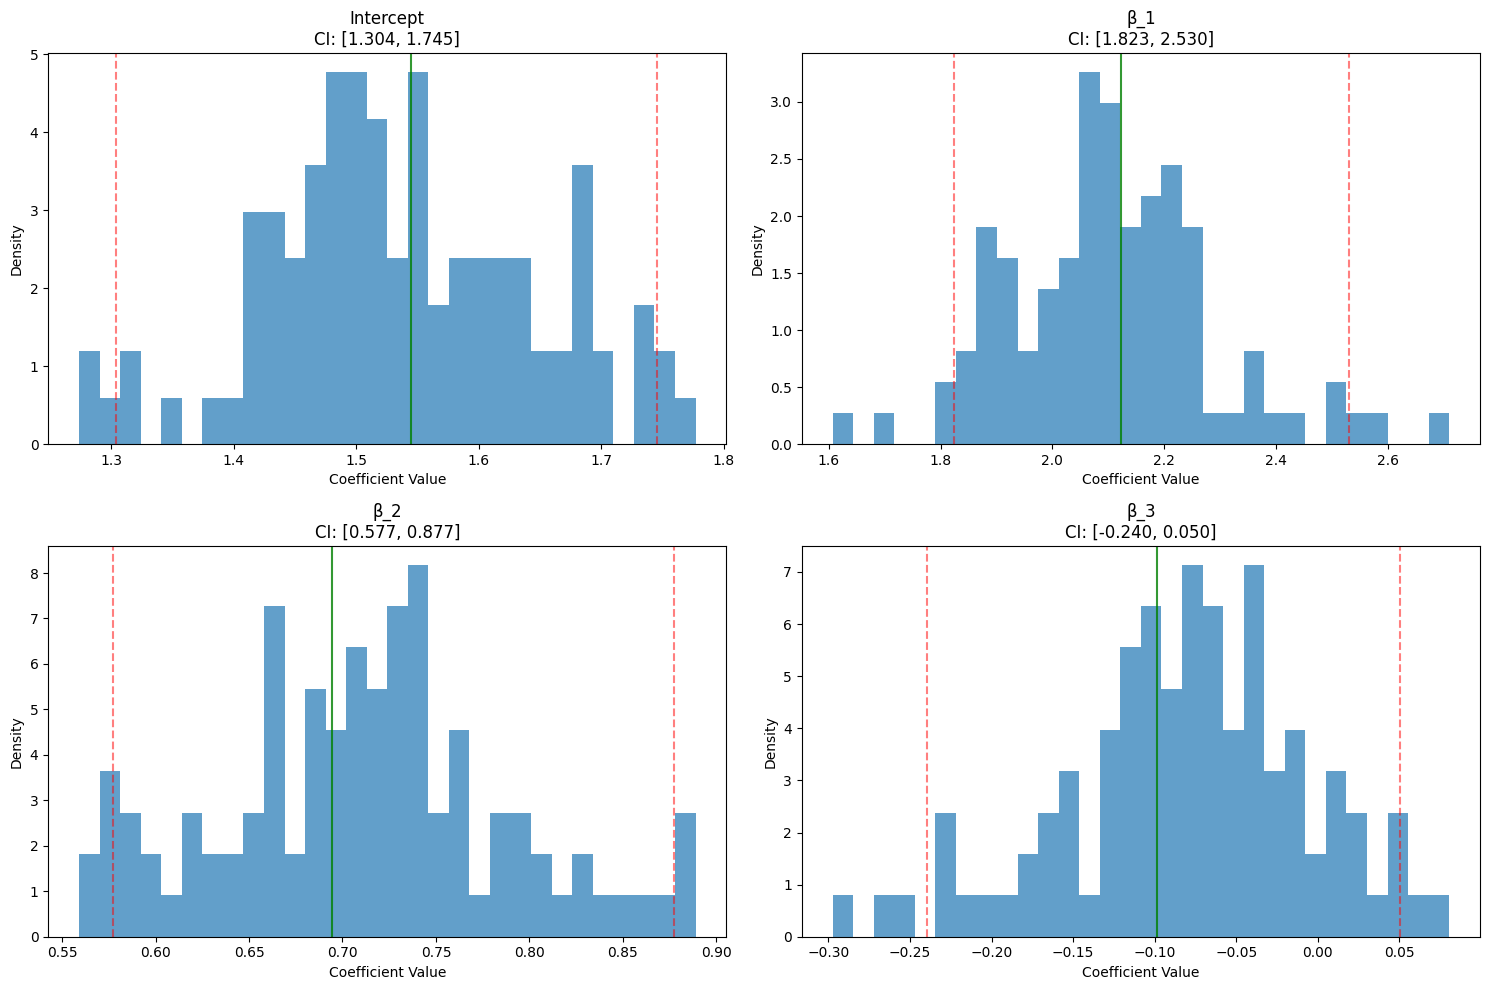

In [12]:
# your code here
from sklearn.utils import resample


## plot the distribution of coefficients -- for reusability 
def plot_coefficient_distributions(coef_samples, original_coefs, n_rows=2):
    n_coefs = coef_samples.shape[1]
    n_cols = int(np.ceil(n_coefs / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axes = axes.ravel()
    
    for i in range(n_coefs):
        #  confidence intervals
        ci_lower = np.percentile(coef_samples[:, i], 2.5)
        ci_upper = np.percentile(coef_samples[:, i], 97.5)
        
        # histogram
        axes[i].hist(coef_samples[:, i], bins=30, density=True, alpha=0.7)
        
        #  vertical lines for CI bounds and original coefficient
        axes[i].axvline(ci_lower, color='r', linestyle='--', alpha=0.5)
        axes[i].axvline(ci_upper, color='r', linestyle='--', alpha=0.5)
        axes[i].axvline(original_coefs[i], color='g', linestyle='-', alpha=0.8)
        
        # labels
        if i == 0:
            coef_name = 'Intercept'
        else:
            coef_name = f'β_{i}'
        axes[i].set_title(f'{coef_name}\nCI: [{ci_lower:.3f}, {ci_upper:.3f}]')
        axes[i].set_xlabel('Coefficient Value')
        axes[i].set_ylabel('Density')
    
    # empty subplots if any
    for i in range(n_coefs, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    return fig

# original coefficients including intercept
original_coefs = np.append(poly_reg.intercept_, poly_reg.coef_)

# array to store bootstrapped coefficients
n_bootstraps = 100
n_coefs = len(original_coefs)
bootstrap_coefs = np.zeros((n_bootstraps, n_coefs))

#bootstrapping
for i in range(n_bootstraps):

    X_boot, y_boot = resample(x_poly_train, train_data['Perc_population'])
    

    boot_model = LinearRegression()
    boot_model.fit(X_boot, y_boot)
    

    bootstrap_coefs[i] = np.append(boot_model.intercept_, boot_model.coef_)


print("Original Model Coefficients:")
for i, coef in enumerate(original_coefs):
    name = 'Intercept' if i == 0 else f'β_{i}'
    print(f"{name}: {coef:.4f}")


ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)

print("\n95% Confidence Intervals:")
for i in range(n_coefs):
    name = 'Intercept' if i == 0 else f'β_{i}'
    print(f"{name}: [{ci_lower[i]:.4f}, {ci_upper[i]:.4f}]")


plot_coefficient_distributions(bootstrap_coefs, original_coefs)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.5</b></div>

Linear regression can be viewed probabilistically, with deviations from the regression line attributed to an error term, $ \epsilon $, distributed as:

$$ \epsilon \sim N(0, \sigma^2) $$

In this question, you'll estimate confidence intervals for the regression coefficients based on this probabilistic perspective. Follow these steps:

1. Compute $ \hat{\sigma}_\epsilon^2 $, an estimate for the variance of the error term.
2. Utilizing this estimated variance, derive the standard errors for your regression coefficients.
3. Construct 95% confidence intervals for the coefficients using their standard errors. For the z-value, use 1.96.
4. Visualize the 95% confidence intervals alongside those from the bootstrap method. The values of the interval bounds should be made explicit in the plot.

**Hints:**
- Ensure your design matrix, $ X $, includes an intercept column to compute a confidence interval for $ \beta_0 $.
- Bootstrap samples play no role in this calculation.

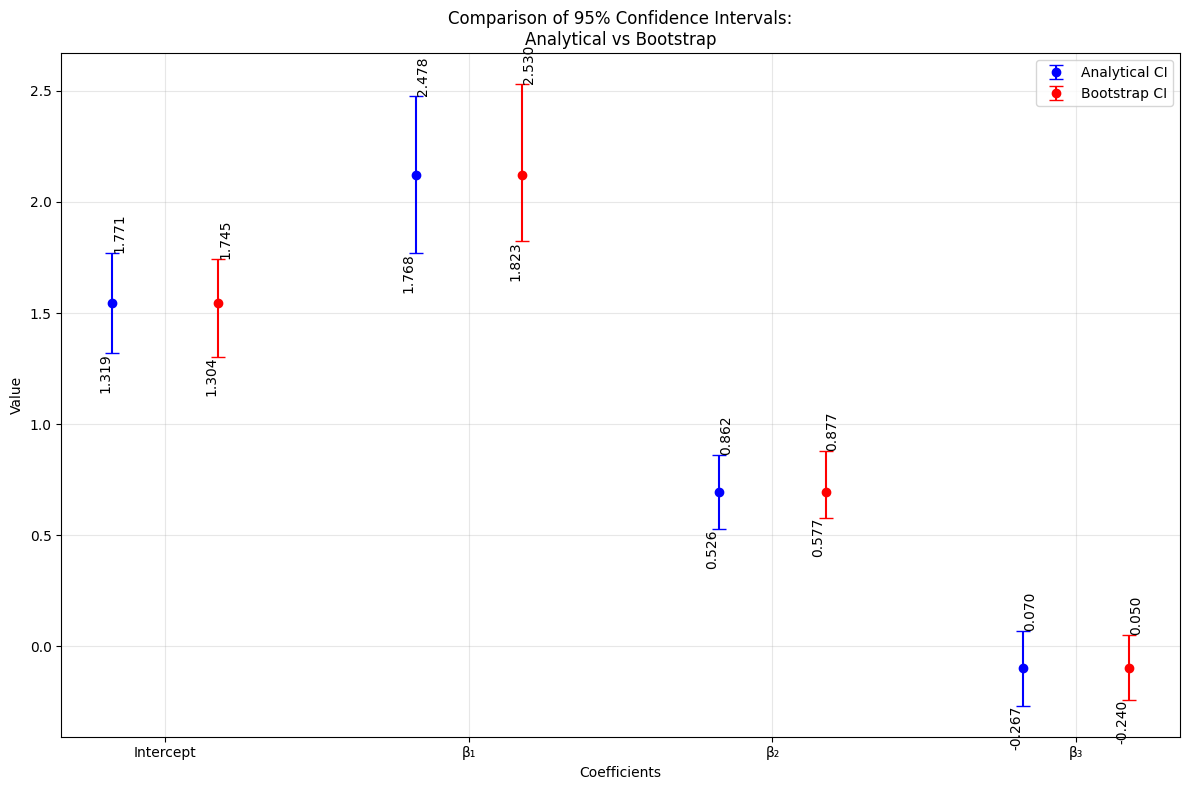


Comparison of Confidence Intervals:

Analytical Method:
Intercept: [1.3185, 1.7714]
β_1: [1.7685, 2.4783]
β_2: [0.5265, 0.8620]
β_3: [-0.2673, 0.0701]

Bootstrap Method:
Intercept: [1.3037, 1.7454]
β_1: [1.8234, 2.5301]
β_2: [0.5774, 0.8773]
β_3: [-0.2399, 0.0505]


In [13]:
# add intercept column to design matrix
X = np.column_stack([np.ones(len(x_poly_train)), x_poly_train])

beta_hat = np.linalg.inv(X.T @ X) @ X.T @ train_data['Perc_population']
y_pred = X @ beta_hat

# sigma_hat_squared (estimated error variance)
n = len(X) 
p = X.shape[1] 
residuals = train_data['Perc_population'] - y_pred
sigma_hat_squared = np.sum(residuals**2) / (n - p)

# Var(beta_hat) = sigma^2 * (X'X)^-1
var_beta_hat = sigma_hat_squared * np.linalg.inv(X.T @ X)
se_beta = np.sqrt(np.diag(var_beta_hat))

z_value = 1.96
ci_lower_analytical = beta_hat - z_value * se_beta
ci_upper_analytical = beta_hat + z_value * se_beta


fig, ax = plt.subplots(figsize=(12, 8))
coef_positions = np.arange(len(beta_hat))
width = 0.35

analytical_ci = ax.errorbar(coef_positions - width/2, beta_hat, 
                          yerr=z_value * se_beta,
                          fmt='o', color='blue', capsize=5, 
                          label='Analytical CI')

# bootstrap CIs
bootstrap_ci = ax.errorbar(coef_positions + width/2, original_coefs,
                         yerr=[original_coefs - ci_lower, 
                              ci_upper - original_coefs],
                         fmt='o', color='red', capsize=5,
                         label='Bootstrap CI')

# plot
ax.set_xticks(coef_positions)
ax.set_xticklabels(['Intercept', 'β₁', 'β₂', 'β₃'])
ax.set_xlabel('Coefficients')
ax.set_ylabel('Value')
ax.set_title('Comparison of 95% Confidence Intervals:\nAnalytical vs Bootstrap')
ax.grid(True, alpha=0.3)
ax.legend()


for i in range(len(beta_hat)):

    ax.text(i - width/2, ci_lower_analytical[i], 
            f'{ci_lower_analytical[i]:.3f}', 
            rotation=90, ha='right', va='top')
    ax.text(i - width/2, ci_upper_analytical[i], 
            f'{ci_upper_analytical[i]:.3f}', 
            rotation=90, ha='left', va='bottom')
    

    ax.text(i + width/2, ci_lower[i], 
            f'{ci_lower[i]:.3f}', 
            rotation=90, ha='right', va='top')
    ax.text(i + width/2, ci_upper[i], 
            f'{ci_upper[i]:.3f}', 
            rotation=90, ha='left', va='bottom')

plt.tight_layout()
plt.show()

print("\nComparison of Confidence Intervals:")
print("\nAnalytical Method:")
for i, (lower, upper) in enumerate(zip(ci_lower_analytical, ci_upper_analytical)):
    name = 'Intercept' if i == 0 else f'β_{i}'
    print(f"{name}: [{lower:.4f}, {upper:.4f}]")

print("\nBootstrap Method:")
for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
    name = 'Intercept' if i == 0 else f'β_{i}'
    print(f"{name}: [{lower:.4f}, {upper:.4f}]")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.6</b></div>

Reflect on the differences between the two sets of confidence intervals. Demonstrate at least one diagnostic making use of the model and/or training data to explore the potential reasons for any observed discrepancies in the confidence intervals. Be sure to explain the relevance of your diagnostic(s) to this particular task and interpret the results.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

This violation of the normality assumption explains why the bootstrap CIs, which don't rely on this assumption, are slightly different from (and generally wider than) the analytical intervals, making them maybe more reliable for this data.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

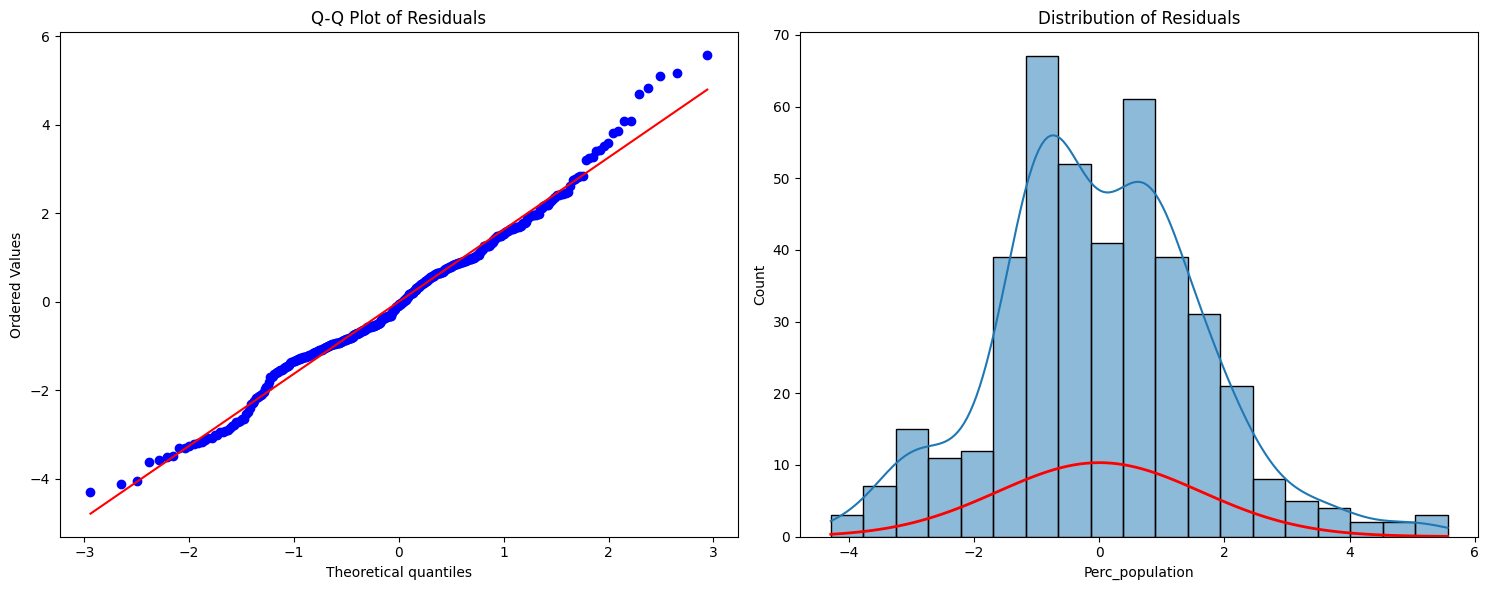

Shapiro-Wilk test p-value: 0.0019


In [14]:
# your code here
residuals = train_data['Perc_population'] - y_pred

# Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot of Residuals")

# Histogram
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_title("Distribution of Residuals")

# Add normal  curve
x = np.linspace(residuals.min(), residuals.max(), 100)
mu, std = np.mean(residuals), np.std(residuals)
normal_curve = stats.norm.pdf(x, mu, std)
ax2.plot(x, normal_curve * len(residuals) * (x[1]-x[0]), 'r-', lw=2)

plt.tight_layout()
plt.show()

#  Shapiro-Wilk test for normality!!!
_, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Single validation set [12 pts]</div> 

In this section you'll find the best degree polynomial relationship using a single validation set.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1</b></div>

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

In [15]:
train_data = pd.read_csv('data/bacteria_train.csv') # for clarity between questions


x_train = train_data[['Spreading_factor']]
y_train = train_data['Perc_population']


x_train80, x_val, y_train80, y_val = train_test_split(
    x_train,           
    y_train,          
    test_size=0.20,   
    random_state=1     
)

In [16]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2</b></div>

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

In [17]:
# your code here

train_mses = []
val_mses = []

# For each degree from 1 to 30
for degree in range(1, 31):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    
    # Transform the training and validation features
    X_train_poly = poly.fit_transform(x_train80)
    X_val_poly = poly.transform(x_val)
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train80)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    
    # Calculate and store MSEs
    train_mse = mean_squared_error(y_train80, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    train_mses.append(train_mse)
    val_mses.append(val_mse)

    print(f"Degree: {degree}, Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")

Degree: 1, Train MSE: 3.0267, Validation MSE: 3.3945
Degree: 2, Train MSE: 2.5830, Validation MSE: 2.9765
Degree: 3, Train MSE: 2.5803, Validation MSE: 2.9537
Degree: 4, Train MSE: 2.4730, Validation MSE: 2.9749
Degree: 5, Train MSE: 2.4729, Validation MSE: 2.9752
Degree: 6, Train MSE: 2.4643, Validation MSE: 2.9543
Degree: 7, Train MSE: 2.4625, Validation MSE: 2.9205
Degree: 8, Train MSE: 2.4275, Validation MSE: 2.9151
Degree: 9, Train MSE: 2.4266, Validation MSE: 2.9192
Degree: 10, Train MSE: 2.4253, Validation MSE: 2.9238
Degree: 11, Train MSE: 2.4247, Validation MSE: 2.9292
Degree: 12, Train MSE: 2.4247, Validation MSE: 2.9265
Degree: 13, Train MSE: 2.4238, Validation MSE: 2.9034
Degree: 14, Train MSE: 2.4180, Validation MSE: 2.8820
Degree: 15, Train MSE: 2.4162, Validation MSE: 2.8802
Degree: 16, Train MSE: 2.4122, Validation MSE: 2.9011
Degree: 17, Train MSE: 2.4078, Validation MSE: 2.9789
Degree: 18, Train MSE: 2.4075, Validation MSE: 2.9648
Degree: 19, Train MSE: 2.4043, Valida

In [18]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3</b></div>

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful.

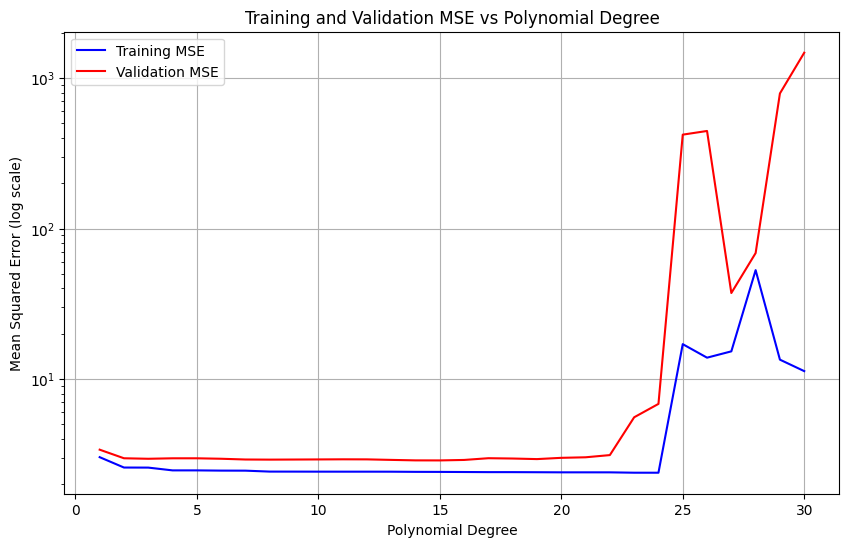

In [19]:
# your code here
plt.figure(figsize=(10, 6))


degrees = range(1, 31)
plt.semilogy(degrees, train_mses, 'b-', label='Training MSE')
plt.semilogy(degrees, val_mses, 'r-', label='Validation MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Training and Validation MSE vs Polynomial Degree')
plt.grid(True)
plt.legend()

In [20]:
# your code here
optimal_degree = np.argmin(val_mses) + 1  # +1 because degrees start at 1

print(f"The optimal polynomial degree is {optimal_degree} with validation MSE of {val_mses[optimal_degree-1]:.4f}")

The optimal polynomial degree is 15 with validation MSE of 2.8802


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.4</b></div>

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

In [21]:
# your code here
#? # why are we using the complete training set instead of hte test set?
# ? i will include it for clarity because i don't understand why we wouldn't use it yet

X_train_combined = x_train  
y_train_combined = y_train  # This is already our complete training set


test_data = pd.read_csv('data/bacteria_test.csv')
x_test = test_data[['Spreading_factor']]
y_test = test_data['Perc_population']


poly = PolynomialFeatures(degree=optimal_degree)


X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(x_test)


model = LinearRegression()
model.fit(X_train_poly, y_train_combined)

# Calculate MSE for both train and test sets
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_mse = mean_squared_error(y_train_combined, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Create dictionary with results
result_dict = {
    'model': '3.4',
    'train_mse': float(train_mse),
    'test_mse': float(test_mse)
}


results.append(result_dict)


In [22]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.653407,2.651906
1,3.4,2.490946,2.736483


In [23]:
grader.check("q3.4")

q3.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.5</b></div>

Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from [Question 2](#part2solutions).

The guesstimated value was VERY different from the true optimmal (15). this highlights teh importance of acltually systematically calculating the values of the regression instead of just guessing. it is interesting htat beta 3 was not signficiant before but values up to beta 15 make this plot best for MSE. 

Optimal polynomial degree: 15
Training MSE: 2.4909
Test MSE: 2.7365


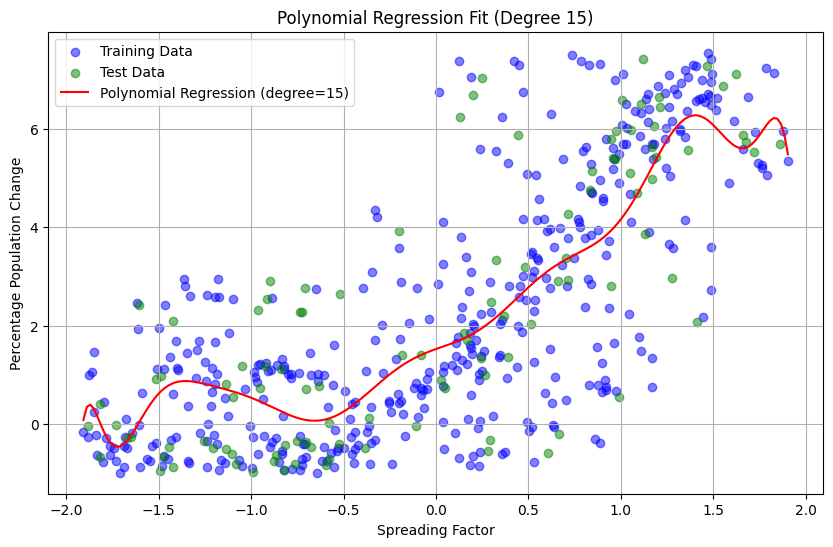

In [24]:
X_smooth = np.linspace(min(x_train.values.min(), x_test.values.min()), 
                      max(x_train.values.max(), x_test.values.max()), 
                      200).reshape(-1, 1)
poly = PolynomialFeatures(degree=optimal_degree)
X_smooth_poly = poly.fit_transform(X_smooth)
y_smooth = model.predict(X_smooth_poly)


plt.figure(figsize=(10, 6))

# Plot both training and test data 
plt.scatter(x_train, y_train, color='blue', alpha=0.5, label='Training Data')
plt.scatter(x_test, y_test, color='green', alpha=0.5, label='Test Data')

#plot
plt.plot(X_smooth, y_smooth, color='red', label=f'Polynomial Regression (degree={optimal_degree})')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage Population Change')
plt.title(f'Polynomial Regression Fit (Degree {optimal_degree})')
plt.legend()
plt.grid(True)


print(f"Optimal polynomial degree: {optimal_degree}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

plt.show()

<a id="part4"></a>

## <div class='exercise'>Question 4: Finding the best model by k-fold cross validation [14 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1</b></div>

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`
    

In [25]:
# your code here
from sklearn.pipeline import make_pipeline

train_mses_mean = []
val_mses_mean = []
val_mses_std = []

# For each degree from 1 to 30
for degree in range(1, 31):
    # Create pipeline
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )
    
    # Perform cross validation
    cv_results = cross_validate(
        model,
        x_train,  # Assuming this is your input data
        y_train,  # Assuming this is your target data
        cv=10,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )
    
    # Store mean training MSE (convert from negative to positive)
    train_mses_mean.append(-cv_results['train_score'].mean())
    
    # Store mean validation MSE (convert from negative to positive)
    val_mses_mean.append(-cv_results['test_score'].mean())
    
    # Store standard deviation of validation MSE
    val_mses_std.append(-cv_results['test_score'].std())

In [26]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2</b></div>

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 4.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

 degree 8 achieves the optimal balance between model complexity and predictive performance, with a validation MSE of 2.5991 and a relatively close training MSE of 2.5081 indicating good generalization without overfitting. The small gap between training and validation MSE suggests the model is well-calibrated

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

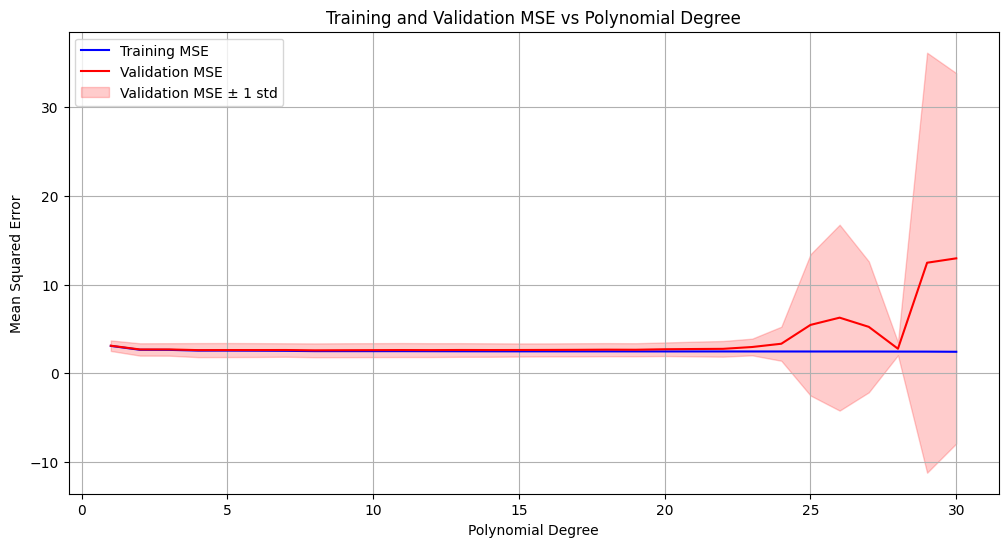

Best polynomial degree: 8
Training MSE at best degree: 2.5081
Validation MSE at best degree: 2.5991


In [27]:
# your code here
train_mses_mean = []
val_mses_mean = []
val_mses_std = []

# For each degree from 1 to 30
for degree in range(1, 31):
    # Create pipeline
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )
    
    # Perform cross validation
    cv_results = cross_validate(
        model,
        x_train,
        y_train,
        cv=10,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )
    
    # Store metrics (converting from negative to positive)
    train_mses_mean.append(-cv_results['train_score'].mean())
    val_mses_mean.append(-cv_results['test_score'].mean())
    val_mses_std.append(cv_results['test_score'].std())

# Create the plot
plt.figure(figsize=(12, 6))

# Plot training MSE
plt.plot(range(1, 31), train_mses_mean, 'b-', label='Training MSE')

# Plot validation MSE with error bounds
plt.plot(range(1, 31), val_mses_mean, 'r-', label='Validation MSE')
plt.fill_between(range(1, 31), 
                 np.array(val_mses_mean) - np.array(val_mses_std),
                 np.array(val_mses_mean) + np.array(val_mses_std),
                 color='r', alpha=0.2, label='Validation MSE ± 1 std')

plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

# Find the best degree
best_degree = np.argmin(val_mses_mean) + 1  # Add 1 because degrees start at 1
print(f"Best polynomial degree: {best_degree}")
print(f"Training MSE at best degree: {train_mses_mean[best_degree-1]:.4f}")
print(f"Validation MSE at best degree: {val_mses_mean[best_degree-1]:.4f}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3</b></div>

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 4.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list. 

In [28]:
# your code here
best_model = make_pipeline(
    PolynomialFeatures(degree=8, include_bias=False),
    LinearRegression()
)

# training data
best_model.fit(x_train, y_train)

# train MSE
y_train_pred = best_model.predict(x_train)
train_mse = np.mean((y_train - y_train_pred) ** 2)

# test MSE
y_test_pred = best_model.predict(x_test)
test_mse = np.mean((y_test - y_test_pred) ** 2)

# dictionary
result = {
    'model': '4.3',
    'train_mse': float(train_mse),
    'test_mse': float(test_mse)
}


results.append(result)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Train MSE: 2.5125
Test MSE: 2.6130


In [29]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4</b></div>

- Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 3](#part3solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

This model seems to fixt htedata well -- similarly to the beta 15 model. This is interesting because it has almost half the number of parameters yet they ahave similar MSE, shape, and fit. I would prefer to use a smaller parameter model when I have the option.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


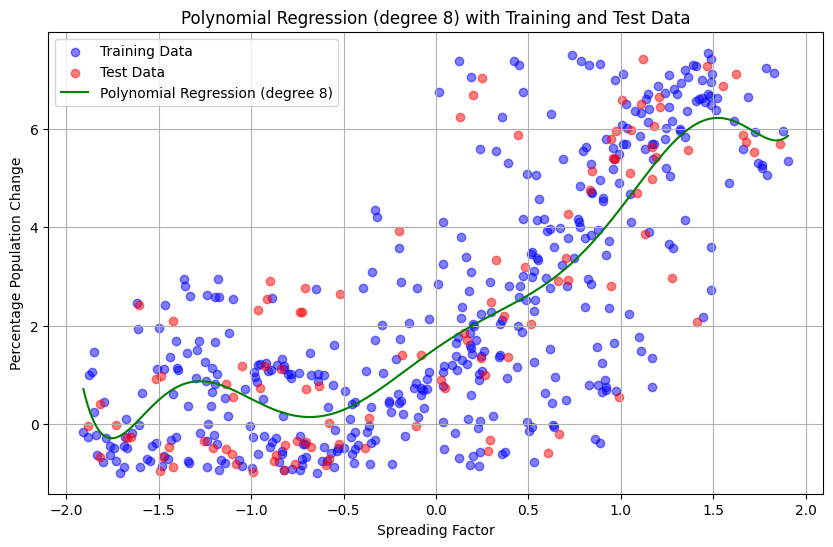


Model Coefficients:
  Feature  Coefficient
0     x^1     2.597028
1     x^2    -1.094868
2     x^3    -1.189134
3     x^4     3.483149
4     x^5     0.652877
5     x^6    -1.713008
6     x^7    -0.115305
7     x^8     0.240418

Results Summary:
  model train_mse  test_mse
0   2.2  2.653407  2.651906
1   3.4  2.490946  2.736483
2   4.3  2.512517  2.613011


In [30]:
# your code here

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color='blue', alpha=0.5, label='Training Data')
plt.scatter(x_test, y_test, color='red', alpha=0.5, label='Test Data')

# Create smooth curve points
x_curve = np.linspace(float(x_train.min()), float(x_train.max()), 1000)
x_curve = x_curve.reshape(-1, 1)  # Reshape for prediction
y_curve = best_model.predict(x_curve)

# Plot the curve
plt.plot(x_curve, y_curve, color='green', label='Polynomial Regression (degree 8)')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage Population Change')
plt.title('Polynomial Regression (degree 8) with Training and Test Data')
plt.legend()
plt.grid(True)
plt.show()

poly_features = best_model.named_steps['polynomialfeatures']
linear_model = best_model.named_steps['linearregression']
coefficients = pd.DataFrame({
    'Feature': [f'x^{i+1}' for i in range(8)],
    'Coefficient': linear_model.coef_
})
print("\nModel Coefficients:")
print(coefficients)


results_df = pd.DataFrame(results).astype(object)
print("\nResults Summary:")
print(results_df)

<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.1</b></div>

In the previous part, we used $k$-fold cross validation to find the best model. But how confident are you of your estimated best degree? We have already used bootstraps in [Question 2.4](#part2) to estimate the confidence intervals of our $\beta_i$ values. In this segment, we will use bootstrapping to test the robustness of our estimation.

- Similar to Question 2.4, **use 100 bootstraps** of your data.
- For each bootstrap:
  - Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ *for each polynomial regression* of **degrees 1 to 30 (inclusive)**.
  - Select the best degree polynomial based on the lowest mean cross-validation MSE and store this degree in a list called `best_degrees`.
- After completing your bootstraps, `best_degrees` should have 100 elements, one degree for each completed bootstrap.

**NOTE:** Once complete, your code for this problem will likely take several minutes to execute. This is to be expected.

In [31]:
def find_best_degree(X, y):
    """
    return the degree with lowest mean validation mse
    """
    val_mses_mean = []
    
    for degree in range(1, 31):
        model = make_pipeline(
            PolynomialFeatures(degree=degree, include_bias=False),
            LinearRegression()
        )
        
        #  cross validation
        cv_results = cross_validate(
            model,
            X,
            y,
            cv=10,
            scoring='neg_mean_squared_error'
        )
        
        # Store mean validation MSE
        val_mses_mean.append(-cv_results['test_score'].mean())
    

    return int(np.argmin(val_mses_mean) + 1)  # explicitly convert to int bc test needs it


best_degrees = []

# bootstraps
for _ in range(100):

    X_boot, y_boot = resample(x_train, y_train)
    best_degree = find_best_degree(X_boot, y_boot)
    best_degrees.append(best_degree)

In [32]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.2</b></div>

Generate a well-labeled bar plot, with the polynomial degree on the $x$-axis and the number of times that degree was deemed best on the $y$-axis, using the `best_degrees` saved during your bootstraps.

**Hint:** You may want to make use of `Counter` which has been imported for your from the `collections` module of the standard Python library.

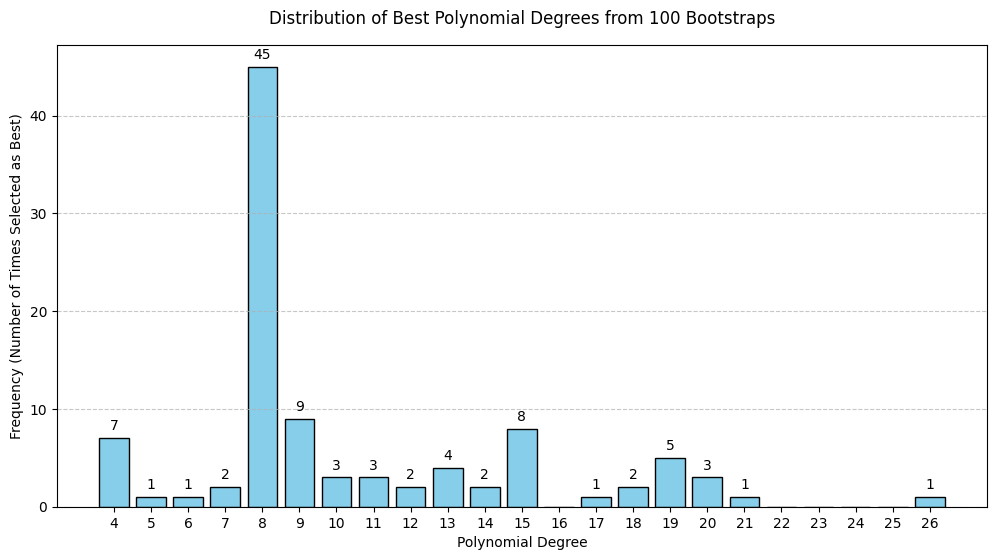

In [33]:
# your code here
degree_counts = Counter(best_degrees)

min_degree = min(degree_counts.keys())
max_degree = max(degree_counts.keys())
degrees = list(range(min_degree, max_degree + 1))
counts = [degree_counts.get(degree, 0) for degree in degrees]

# bar plot
plt.figure(figsize=(12, 6))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='black')


plt.title('Distribution of Best Polynomial Degrees from 100 Bootstraps', pad=15)
plt.xlabel('Polynomial Degree')
plt.ylabel('Frequency (Number of Times Selected as Best)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(degrees)


for i, count in enumerate(counts):
    if count > 0:  
        plt.text(degrees[i], count + 0.5, str(count), 
                ha='center', va='bottom')

plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.3</b></div>

What are your observations from the plot above? 

- Why do you see so much variation in the "best degree" over the bootstraps?
- Which degree polynomial regression will you choose as your overall best degree based on your bootstrapped results, and why? 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

- We see so much variation because bootstraps create inherent variation. This does not imply the amount that they are better, just the fact that they are different. this means that maybe they are n;t that different in a certain range. 
- I would choose 8 as the best polynomial regression becuase it is by far the most frequently the best of the polynomial degrees.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.4</b></div>

Now, with the overall best degree identified with your bootstrapping results above, train the polynomial regression model on the **complete training set**. Append a new dictionary for this model to your `results` list. 

In [34]:
# your code here

most_common_degree = Counter(best_degrees).most_common(1)[0][0]


final_model = make_pipeline(
    PolynomialFeatures(degree=most_common_degree, include_bias=False),
    LinearRegression()
)


final_model.fit(x_train, y_train)


train_pred = final_model.predict(x_train)
test_pred = final_model.predict(x_test)

train_mse = np.mean((y_train - train_pred) ** 2)
test_mse = np.mean((y_test - test_pred) ** 2)


result = {
    'model': '5.4',
    'train_mse': float(train_mse),
    'test_mse': float(test_mse)
}

results.append(result)

print(f"Most common degree from bootstrapping: {most_common_degree}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Most common degree from bootstrapping: 8
Train MSE: 2.5125
Test MSE: 2.6130


In [35]:
grader.check("q5.4")

q5.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.5</b></div>

- Generate a plot of the data and your regression curve.
- Display `results` as a DataFrame.
- Comment on how your model fits the data and compare it to the fit of your cross-validated model from [Question 4](#part4solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

This is the same curve with all teh same properties as the one in qustion 4. It still fits the data well . 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


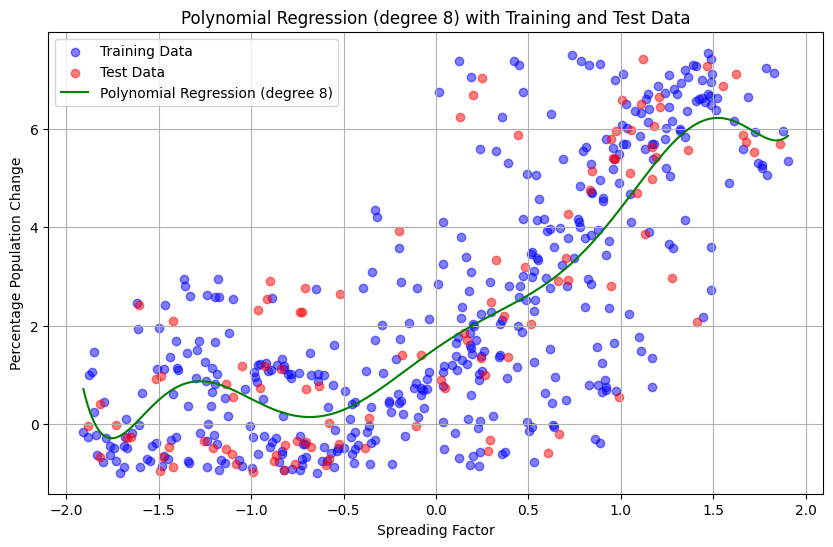


Results Summary:
  model train_mse  test_mse
0   2.2  2.653407  2.651906
1   3.4  2.490946  2.736483
2   4.3  2.512517  2.613011
3   5.4  2.512517  2.613011

Comparison with Cross-validated Model:
Bootstrap Model (degree 8) - Train MSE: 2.5125, Test MSE: 2.6130
Cross-validated Model (degree 8) - Train MSE: 2.5125, Test MSE: 2.6130


In [36]:
plt.figure(figsize=(10, 6))

# Plot training and test data points
plt.scatter(x_train, y_train, color='blue', alpha=0.5, label='Training Data')
plt.scatter(x_test, y_test, color='red', alpha=0.5, label='Test Data')

# Generate smooth curve
x_curve = np.linspace(float(x_train.min()), float(x_train.max()), 1000).reshape(-1, 1)
y_curve = final_model.predict(x_curve)

# Plot the curve
plt.plot(x_curve, y_curve, color='green', 
        label=f'Polynomial Regression (degree {most_common_degree})')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage Population Change')
plt.title(f'Polynomial Regression (degree {most_common_degree}) with Training and Test Data')
plt.legend()
plt.grid(True)
plt.show()

# Display results DataFrame
results_df = pd.DataFrame(results).astype(object)
print("\nResults Summary:")
print(results_df)

print("\nComparison with Cross-validated Model:")
print(f"Bootstrap Model (degree {most_common_degree}) - Train MSE: {results[3]['train_mse']:.4f}, Test MSE: {results[3]['test_mse']:.4f}")
print(f"Cross-validated Model (degree 8) - Train MSE: {results[2]['train_mse']:.4f}, Test MSE: {results[2]['test_mse']:.4f}")

<!-- END QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: Improving model consistency with LASSO regularization [26 pts]</div> 

[Return to contents](#contents)

In the previous sections, we compared many polynomial models to find the best degree. For each model of degree $n$, we considered all polynomial coefficients *up to and including* **degree $n$** using `PolynomialFeatures(...)`. In this section we will consider polynomial features of $n=30$, and a **best model** that could be chosen from any possible combination of our 30 degrees.

For instance, we could choose a best model with an arbitrary set of polynomial degrees up degree 30, such as $x^i \in [x^1, x^5, x^{19}, x^{24}]$, rather than the standard approach of using *all* consecutive degrees up to our maximum degree $n=30$ as in $x^i \in [x^1, ... , x^{30}]$.

However, the total number of such possible models for $n=30$ is $2^{30}\approx10^9$, and searching through all of them would be laborious and computationally inefficient. Instead, we can use $LASSO$ (i.e. $L1$) regularization, which "switches off" highly unstable degree coefficients by shrinking them to zero (or very close to zero), thus giving us an efficient solution to this particular combinatorial challenge.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.1</b></div>

**Find the best hyper-parameter alpha, $\alpha$**

Use the `LassoCV` estimator to find the best regularization parameter from $\alpha \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}]$
- Store the mean cross-validation MSEs across each fold in `lassoCV_val_mses_mean`
- Save the best $\alpha$ based on the mean cross-validation MSE in `best_alpha`

You should read the documentation for [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Some important information about this estimator:
- After calling `fit`, the model is now the one fit on the entire training data using the best alpha based on the mean CV MSE.
- the `mse_path_` attribute contains the validation scores on each fold for each candidate alpha.
- the `alpha_` attribute contains the best regularization parameter found through cross-validation

**Tips:** You should try adjusting `LassoCV`'s `max_iter` argument to prevent convergence warnings. If you are unable to prevent them with a large number of iterations (~100,000) then you can silence them with:
```{python}
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
```
Do not worry about normalizing your $x$ values for any parts of Question 6. It will not meaningfully affect our final results here.

In [37]:
# your code here

from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

poly = PolynomialFeatures(degree=30)
X_train_poly = poly.fit_transform(x_train.values.reshape(-1, 1))

# Create and fit LassoCV model
# Using high max_iter to ensure convergence
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,  # 5-fold cross-validation
    max_iter=100000,
    random_state=42
)
lasso_cv.fit(X_train_poly, y_train)

# Store mean cross-validation MSEs
lassoCV_val_mses_mean = np.mean(lasso_cv.mse_path_, axis=1)

# Store best alpha
best_alpha = lasso_cv.alpha_

In [38]:
grader.check("q6.1")

q6.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.2</b></div>

Generate two plots:
- One showing the mean validation $MSE$ values for each regularization parameter $\alpha$, identifying the best $\alpha$.
- Another showing the values of each coefficient in the LASSO model using the best $\alpha$. 

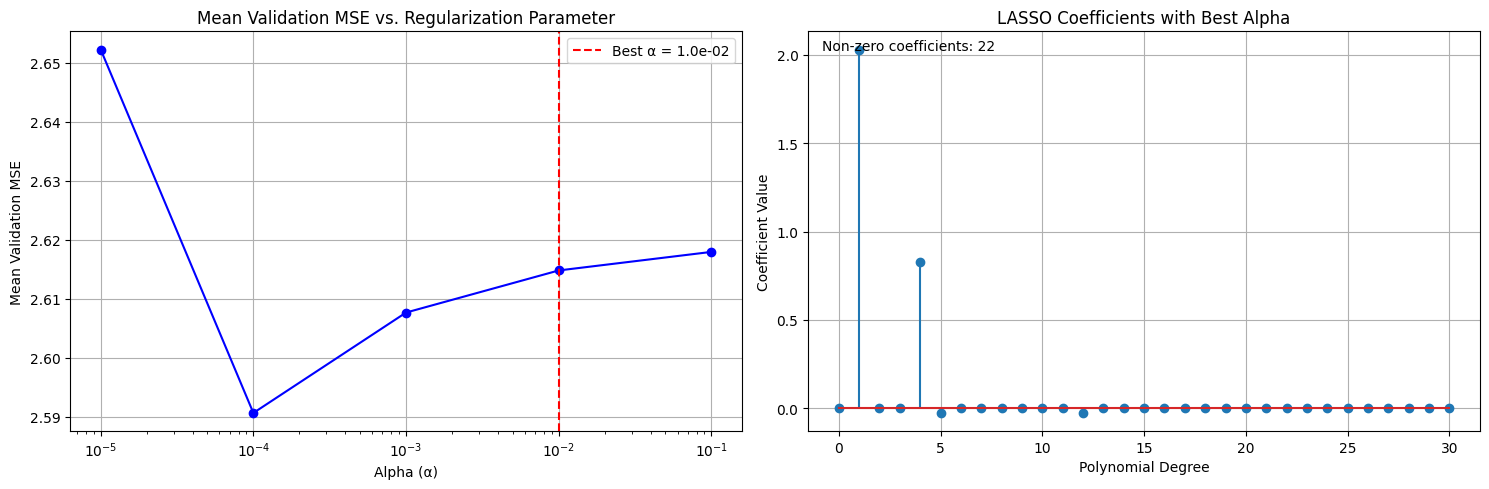

In [39]:
# your code here

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# MSE vs Alpha
ax1.semilogx(alphas, lassoCV_val_mses_mean, 'b-o')
ax1.axvline(best_alpha, color='red', linestyle='--', label=f'Best α = {best_alpha:.1e}')
ax1.set_xlabel('Alpha (α)')
ax1.set_ylabel('Mean Validation MSE')
ax1.set_title('Mean Validation MSE vs. Regularization Parameter')
ax1.grid(True)
ax1.legend()

# Coefficient Values
coef_labels = [f'x^{i}' for i in range(31)]  
coefs = lasso_cv.coef_
nonzero_mask = np.abs(coefs) > 1e-10  # hide non-zero coefficients

markerline, stemlines, baseline = ax2.stem(range(len(coefs)), coefs)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('LASSO Coefficients with Best Alpha')
ax2.grid(True)


ax2.text(0.02, 0.98, f'Non-zero coefficients: {sum(nonzero_mask)}', 
         transform=ax2.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.3</b></div>

**Find the most significant degrees**

**NOTE: The code for this question has been provided. It can take several minutes to run. Just be sure to answer the interpretation part of the question.**

From the previous section, you will now have the `best_alpha` hyperparameter. Now, we will use this best $\alpha$ value to find the "most significant" set of polynomial degrees by using bootstraps.

What we mean by this is, for each bootstrap of the data, you will get some set of degrees that are **significant**, as will be indicated by the value of their coefficients. Typically, while using $LASSO$ regularization, we would consider $\mid\beta_i\mid \gt 0$ as an indication of a particular coefficient's significance. However, for this particular exercise, we are going to use $\mid\beta_i\mid \gt 0.1$ as our criteria for significance (we have found this $0.1$ threshold to work well when designing this particular problem).

Based on this criteria, you will identify which degree coefficients are significant over many bootstrapped iterations with $n=30$ polynomial features and your chosen best $\alpha$ from Question 6.1.

- Use polynomial features with **degree 30**.
- Use a dictionary called `significant_degrees` to store a cumulative count for each degree identified as significant during your bootstraps.
- Run at least 100 bootstraps of your data.
- For each bootstrap:
  - Train a `Lasso(...)` model with the `best_alpha` identified in Question 6.1.
  - Identify the significant polynomial degree coefficients using $\mid\beta_i\mid \gt 0.1 $ as our threshold for significance.
  - For each significant coefficient, update the count of that degree in your `significant_degrees` dictionary.
- Generate a bar plot showing the count for each degree, showing how many times it was identified as significant over your bootstraps.
- Based on this plot, there should likely be a clear maximum degree, above which, few if any iterations have been identified as significant. Interpret your bar plot, choose a maximum degree polynomial based upon it, and explain your rationale for choosing that degree.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_69457/82839026.py:56: SyntaxWarning: invalid escape sequence '\m'
  f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "


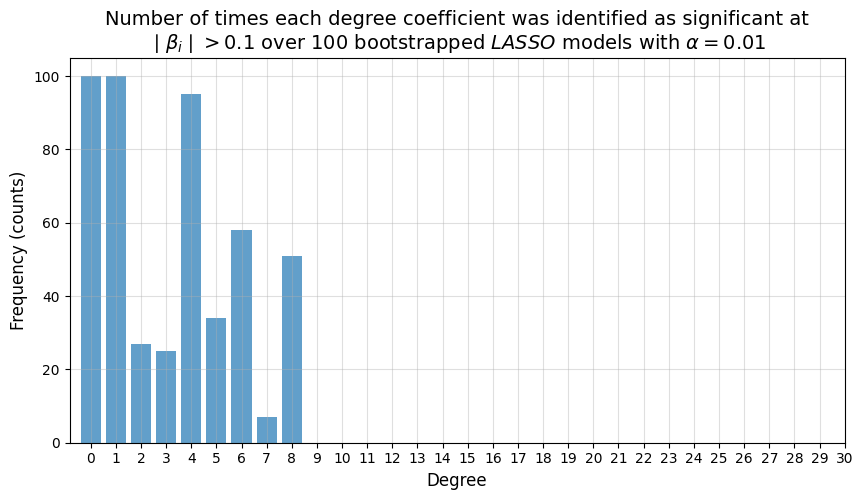

In [40]:
# your code here
best_alpha = 1e-02
# Set bootstrapping parameters
numboot = 100
max_degree = 30

significant_degrees = {}

# Perform bootstraps
df_train = pd.read_csv('data/bacteria_train.csv')

include_bias = False # No column of ones from PolynomialFeatures
fit_intercept = True # We will get it from LinearRegression.fit()

for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Spreading_factor"]]
    x_poly_train_boot = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Perc_population

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=5_000,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train_boot, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        # If you got your constant from PolynomialFeatures and not LinearRegression,
        # then the intercept is actually the first coef in the model.
        # But this would be problematic when using regularization. Can you see why?
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.4</b></div>

From our Question 6.3 results, we can see that only some degrees are consistently significant over many bootstraps.

- Use polynomial features based on the maximum degree you identified using your results from Question 6.3 (for the sake of simplicity, use all degrees up to that maximum degree as is typically done in polynomial regression).
- Train your **LASSO** regularized model using your `best_alpha` hyper-parameter on the entire training set.
- Append a new dictionary for this model to your `results` list.

In [41]:
# your code here
poly = PolynomialFeatures(degree=8, include_bias=False)
X_train_poly = poly.fit_transform(x_train.values.reshape(-1, 1))
X_test_poly = poly.transform(x_test.values.reshape(-1, 1))

# LASSO model with best alpha
final_lasso = Lasso(alpha=best_alpha, max_iter=5000, fit_intercept=True)
final_lasso.fit(X_train_poly, y_train)

# MSE for train and test sets
train_predictions = final_lasso.predict(X_train_poly)
test_predictions = final_lasso.predict(X_test_poly)

train_mse = np.mean((y_train - train_predictions) ** 2)
test_mse = np.mean((y_test - test_predictions) ** 2)

lasso_results = {
    'model': '6.4', 
    'train_mse': float(train_mse),  
    'test_mse': float(test_mse)  
}

# Append to results list
results.append(lasso_results)

In [42]:
grader.check("q6.4")

q6.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.5</b></div>

- Generate a plot of the data and your regression curve.
- Report the polynomial degrees and corresponding coefficients for this fully trained model that have an absolute value greater than 0.1 (i.e. $\mid\beta_i\mid \gt 0.1 $)
- Display `results` as a DataFrame.

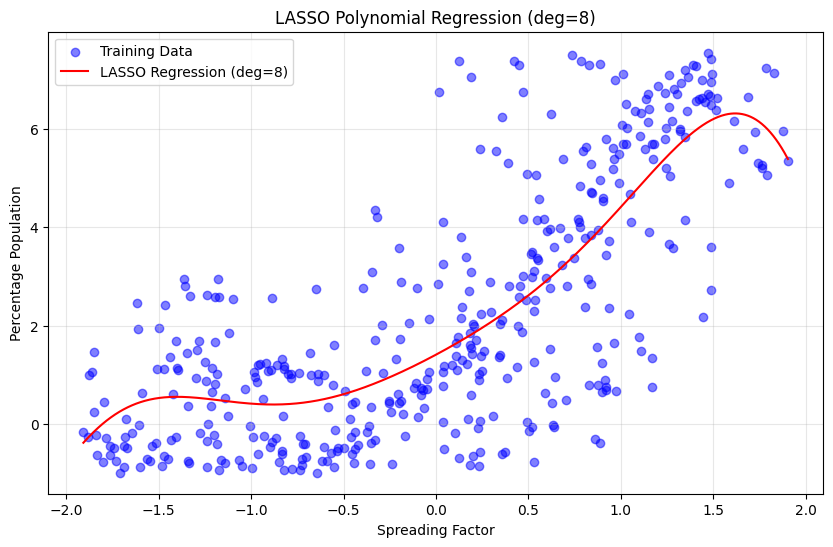


Significant Coefficients (|β| > 0.1):
Intercept: 1.4075
Degree 1: 2.0135
Degree 2: 0.6804
Degree 4: 0.5634
Degree 6: -0.2602

Results Summary:
  model  train_mse  test_mse
0   2.2     2.6534    2.6519
1   3.4     2.4909    2.7365
2   4.3     2.5125    2.6130
3   5.4     2.5125    2.6130
4   6.4     2.5538    2.5920


In [43]:
# your code here

plt.figure(figsize=(10, 6))


plt.scatter(x_train, y_train, color='blue', alpha=0.5, label='Training Data')

# Generate points for smooth curve
x_curve = np.linspace(x_train.min(), x_train.max(), 1000).reshape(-1, 1)
x_curve_poly = poly.transform(x_curve)
y_curve = final_lasso.predict(x_curve_poly)


plt.plot(x_curve, y_curve, color='red', label='LASSO Regression (deg=8)')

plt.xlabel('Spreading Factor')
plt.ylabel('Percentage Population')
plt.title('LASSO Polynomial Regression (deg=8)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display significant coefficients
print("\nSignificant Coefficients (|β| > 0.1):")
significant_coefs = []
for degree, coef in enumerate(final_lasso.coef_):
    if abs(coef) > 0.1:
        significant_coefs.append(f"Degree {degree + 1}: {coef:.4f}")
if abs(final_lasso.intercept_) > 0.1:
    significant_coefs.insert(0, f"Intercept: {final_lasso.intercept_:.4f}")
for coef in significant_coefs:
    print(coef)

# Display results DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df['train_mse'] = results_df['train_mse'].round(4)
results_df['test_mse'] = results_df['test_mse'].round(4)
print("\nResults Summary:")
print(results_df)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.6</b></div>

**What are your observations?**

- Compare your `best_degree` from [Question 5](#part5solutions) with your chosen degree in 6.4 above and comment on the difference.
- Compare your test $MSE$ in this question with the result from question 5. Which one is smaller, and by how much?
- Which degree coefficients in your best fit model from 6.4 are significant? If not all coefficients are significant, why?
- Would you expect your current model from 6.4 to be more "reliable" or robust than the models in Question 5 and prior? On what basis would you make a claim of its robustness?


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

- The best degree is still 8 because it is still frequently significant in the bootstraps and so are the "smaller" (lower value) parameters. 
- The test MST in q 5 is greater than the one in q 6.4. It is very slightly smaller -- .02 smaller.
- The coefficeints that are signficant: intercept, 1, 2, 4, 6. This is NOT all that are contained in it. Some may not be signficant because the patterns are encompassed in other parameters and thus are not as influential
- i would trust the current model to be more reliable because it 1) uses bootstrap which is nonparametric 2) uses LASSO to attempt to reduce overfitting. I am a fan of reducing overfitting

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="part7"></a>

## <div class='exercise'>Question 7: Analyze your best test MSEs for each sub section of the homework [6 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.1</b></div>

Using the `results` list, generate a bar plot illustrating the test $MSE$ values for each of the models. Display `results` as a Dataframe as well.

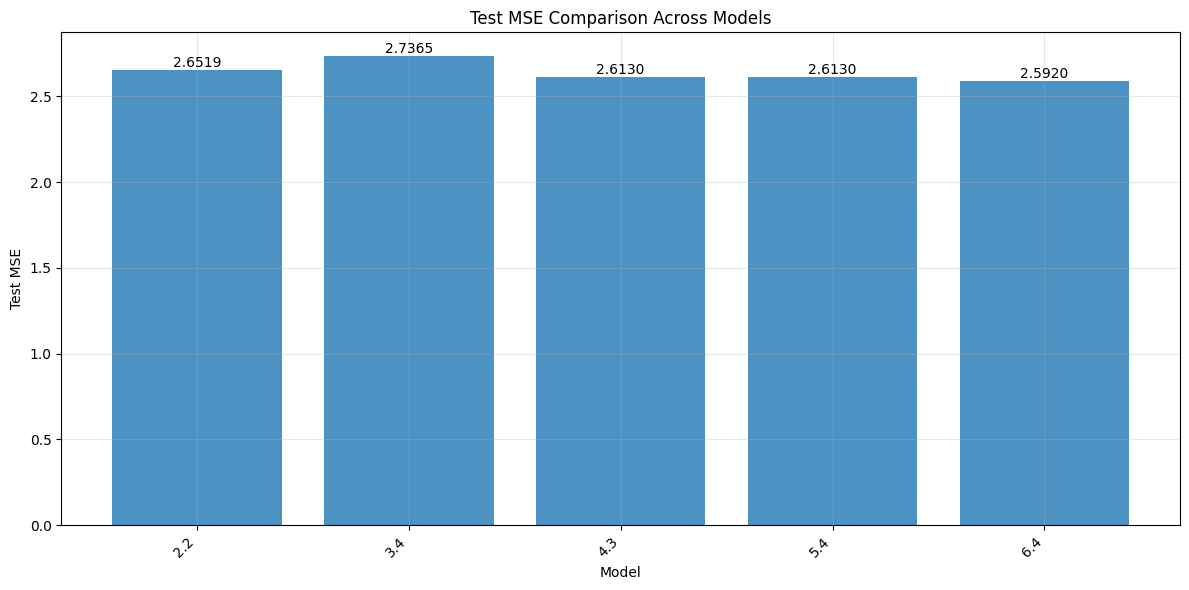


Results Summary:
  model  train_mse  test_mse
0   2.2     2.6534    2.6519
1   3.4     2.4909    2.7365
2   4.3     2.5125    2.6130
3   5.4     2.5125    2.6130
4   6.4     2.5538    2.5920


In [44]:
# your code here
plt.figure(figsize=(12, 6))


model_names = [result['model'] for result in results]
test_mses = [result['test_mse'] for result in results]

bars = plt.bar(model_names, test_mses, alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Test MSE Comparison Across Models')
plt.grid(True, alpha=0.3)
for bar in bars:
   height = bar.get_height()
   plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

plt.tight_layout() 
plt.show()

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df.round(4))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.2</b></div>

Which model do you think is best, and why? What are some of that model's drawbacks compared to the other models? 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

the final model in 6.4 I would think is the best because it has the smallest TEST MSE. This is the key indicator of success because it identifies how the model behaves on unseen data, accounting for possible overfitting and approximating the general fit towards the population data patterns. This model has drawbacks because LASSO produces biased coefficeints--the expected value of the lasso coeffficients is not the true value of the coefficients. this leads to worse interpretability.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I initially struggled with the plots and getting the fit right, but once i had done it a few times, i got the hang of it and was able to identify the common patterns.

interpreting the graphs and why the different methods were actually different even though the graphs look very verry very similar. I found this difficult. However, it is helpful to have the numerical descriptors like ht MSe to show that they are infact different. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [45]:
hours_spent_on_hw = 8

In [46]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [47]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 1.34 minutes for this notebook to run


🌈 **This concludes HW3. Thank you!**

[Return to contents](#contents)